# Imports

In [1]:
%matplotlib inline
#%matplotlib notebook

#Basic stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# ML models
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import make_scorer


# Chemistry
import molvs
from rdkit import Chem
from rdkit.Chem import SaltRemover
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

# Initialize tqdm progress bar
from tqdm import tqdm, tnrange, tqdm_notebook
from tqdm.auto import tqdm
tqdm.pandas(tqdm_notebook)

In [4]:
# Local Packages
%reload_ext autoreload
%autoreload 2
from MTase.ActivityClassifier import AverageRF
from MTase.utils import train_test_split_data, evaluate_classifier_model

# Data

In [5]:
# Load
active = pd.read_pickle("./data/active_df.pkl.bz2")
inactive = pd.read_pickle("./data/inactive_df.pkl.bz2")

# Add active bit for classification tasks
active['ActiveBit']   = True
inactive['ActiveBit'] = False

In [6]:
# Prepare a DataFrame with only the data we need
columns = ['PUBCHEM_SID','mol','ActiveBit']
data = pd.concat([active.filter(columns,axis=1),inactive],
                 axis=0,join='inner', ignore_index=True)

In [16]:
data.index

RangeIndex(start=0, stop=50829, step=1)

In [21]:
# Split the data into train / test
# This will give us indices of a test/train split
X_data_index = data.index
y_data = data['ActiveBit'].values
train_index, test_index, y_train, y_test = train_test_split_data(X_data_index, y_data, rate_inactives=0.90)
print("-"*70)
print("TOTAL:",len(train_index) + len(test_index))

X_train:  7461 	y_train:  7461 	( 746 actives and 6715 inactives)
X_test:   829  	y_test:   829  	( 83 actives and 746 inactives)
----------------------------------------------------------------------
TOTAL: 8290


In [39]:
#y_train = data.iloc[train_index]['ActiveBit'].values
#y_test  = data.iloc[test_index]['ActiveBit'].values

In [100]:
train_test = (train_index, test_index)

# Functions

In [141]:
# Add Fingerprints
#def get_rdkfingerprints(mol):
#    fp = RDKFingerprint(mol)
#    return np.array(list(map(int,fp.ToBitString())))

def add_fingerprints(frame, fp_name, fingerprinter, **fpr_args):
    tqdm.pandas(desc=f"Generating {fp_name} fingerprints")
    frame[fp_name] = frame['mol'].progress_apply(fingerprinter, **fpr_args)
    return

In [159]:
def fit_and_evaluate(model, name, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    res = evaluate_classifier_model(model, X_test, y_test, name)
    res["Model"] = name
    return res

In [147]:
def get_morgan_fp(mol,**kwargs):
    radius = kwargs["radius"]
    use_features = kwargs["use_features"]
    fp = GetMorganFingerprintAsBitVect(mol,radius,useFeatures=use_features)
    return np.array(list(map(int,fp.ToBitString())))

In [161]:
def test_fingerprint(data, train_test, fp_name, fpr, **fpr_args):
    """
    Tests the fingerprint
    
    INPUTS:
      - data: DataFrame with the data
      - fp_name: (str) Name of the fingerprint
      - train_test_indexes: tuple containing 2 arrays: train_index and test_index
      - fpr: a fingerprinter function
      - *fpr_args: extra arguments to be passed to the fingerprinter function
      
    RETURNS:
      - results: (dict) stats for the test set
    """
    
    _data = data.copy()
    
    # Adds the fingerprints
    add_fingerprints(_data, fp_name, fpr, **fpr_args)

    # Define train / test sets
    itrain, itest = train_test
    X_train = np.array(list(_data.iloc[itrain][fp_name])).astype(int)
    X_test  = np.array(list(_data.iloc[itest][fp_name])).astype(int)
    
    y_train = data.iloc[itrain]['ActiveBit'].values
    y_test  = data.iloc[itest]['ActiveBit'].values
    
    # Create the model
    model = RandomForestClassifier(n_estimators=250, bootstrap=True, 
                                   class_weight='balanced_subsample',
                                   criterion='entropy', n_jobs=4, random_state=42)
    
    # Fit and Evaluate model
    res = fit_and_evaluate(model, fp_name, X_train, X_test,y_train, y_test) 

    return _data, res

In [224]:
def test_combined_fingerprint(data, train_test, fp_name):
    """
    Tests the combined fingerprint
    
    INPUTS:
      - fp_name: (str) Name of the fingerprint
      - train_test_indexes: tuple containing 2 arrays: train_index and test_index
      - fpr: a fingerprinter function
      - *fpr_args: extra arguments to be passed to the fingerprinter function
      
    RETURNS:
      - results: (dict) stats for the test set
    """
    
    # Define train / test sets
    itrain, itest = train_test
    X_train = np.array(list(data.iloc[itrain][fp_name])).astype(int)
    X_test  = np.array(list(data.iloc[itest][fp_name])).astype(int)
    
    y_train = data.iloc[itrain]['ActiveBit'].values
    y_test  = data.iloc[itest]['ActiveBit'].values
    
    # Create the model
    model = RandomForestClassifier(n_estimators=250, bootstrap=True, 
                                   class_weight='balanced_subsample',
                                   criterion='entropy', n_jobs=4, random_state=42)
    
    # Fit and Evaluate model
    res = fit_and_evaluate(model, fp_name, X_train, X_test,y_train, y_test) 

    return res

# Test ECFP / FCFP

In [162]:
results = pd.DataFrame(columns=["Model","Precision","Recall","F1_Score", "ROC_AUC"])



------------------------------------------------------------
Fingerprint: ECFP4
------------------------------------------------------------


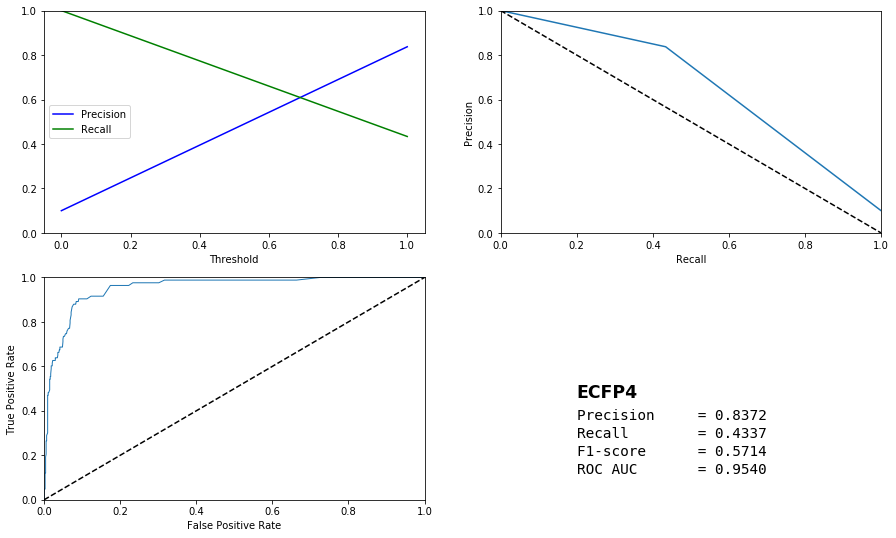



------------------------------------------------------------
Fingerprint: FCFP4
------------------------------------------------------------


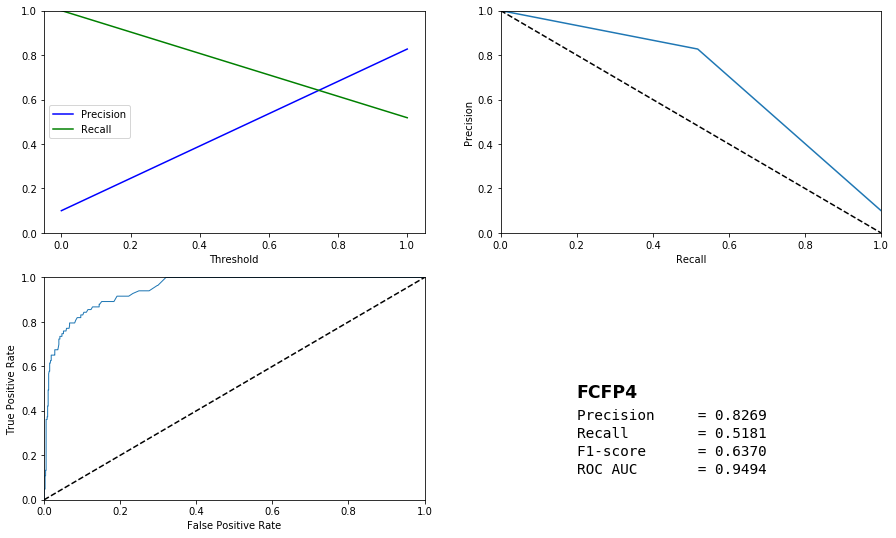



------------------------------------------------------------
Fingerprint: ECFP6
------------------------------------------------------------


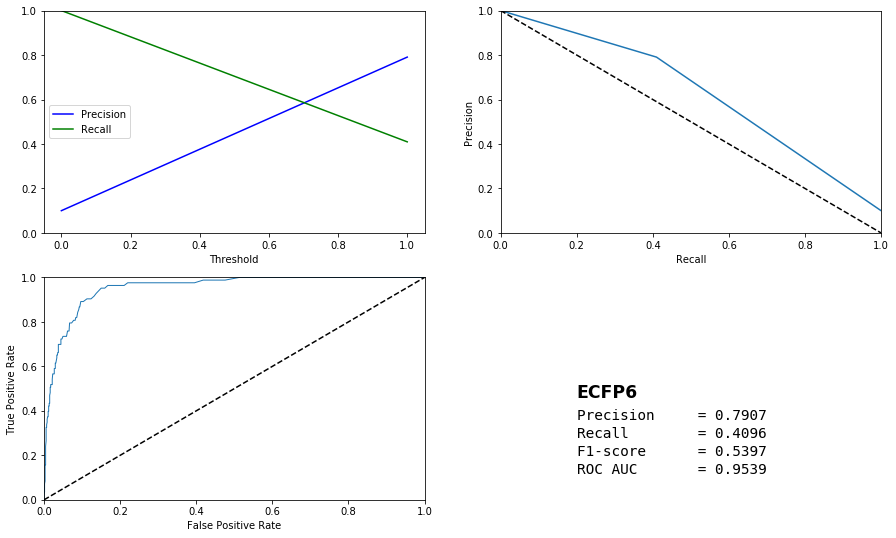



------------------------------------------------------------
Fingerprint: FCFP6
------------------------------------------------------------


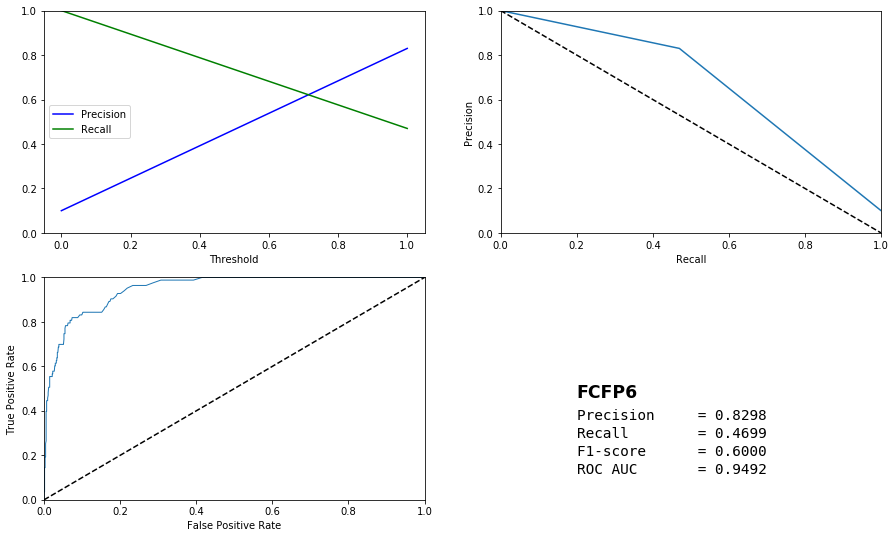



------------------------------------------------------------
Fingerprint: ECFP8
------------------------------------------------------------


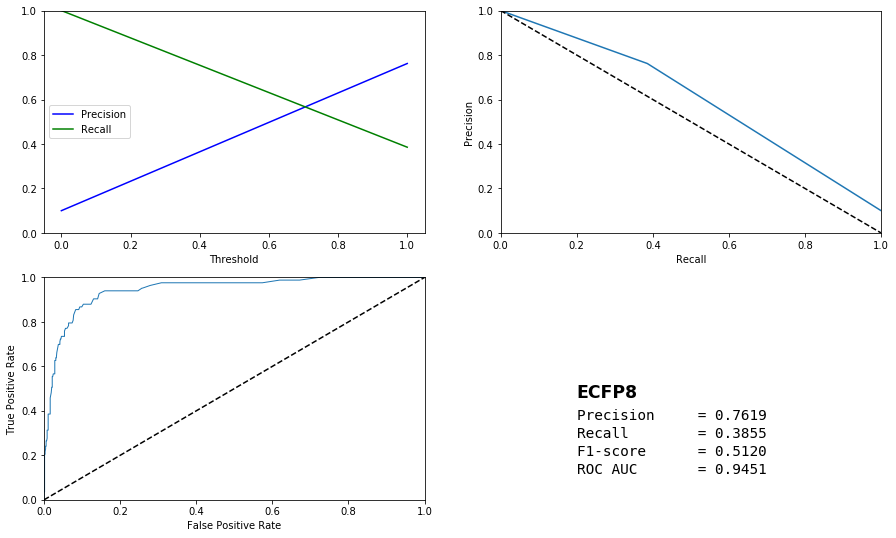



------------------------------------------------------------
Fingerprint: FCFP8
------------------------------------------------------------


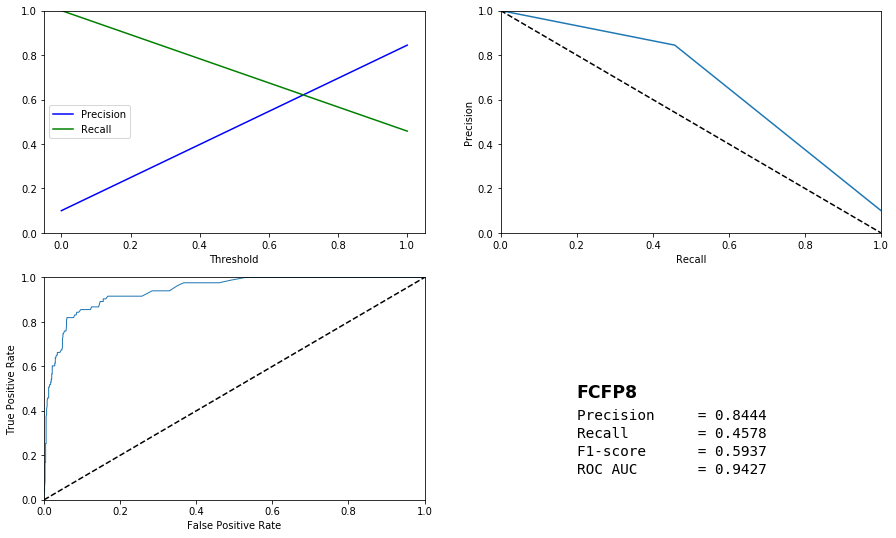



------------------------------------------------------------
Fingerprint: ECFP10
------------------------------------------------------------


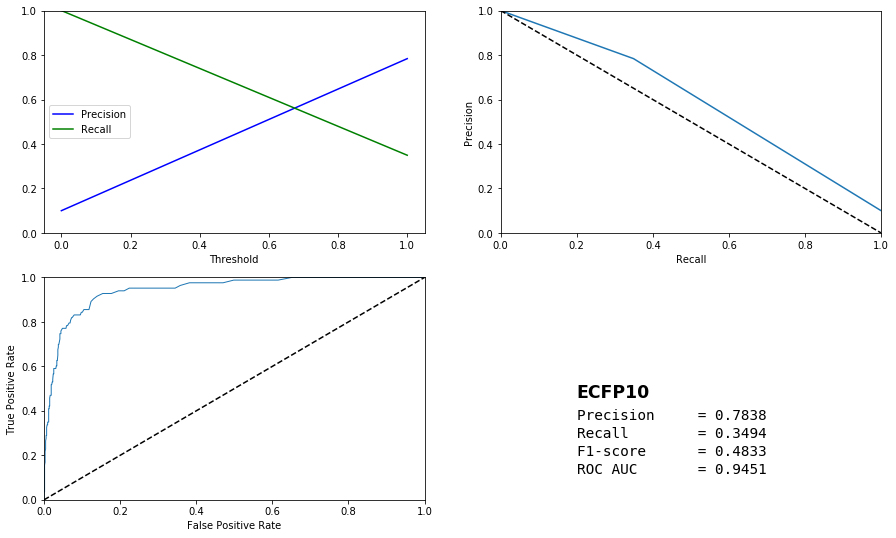



------------------------------------------------------------
Fingerprint: FCFP10
------------------------------------------------------------


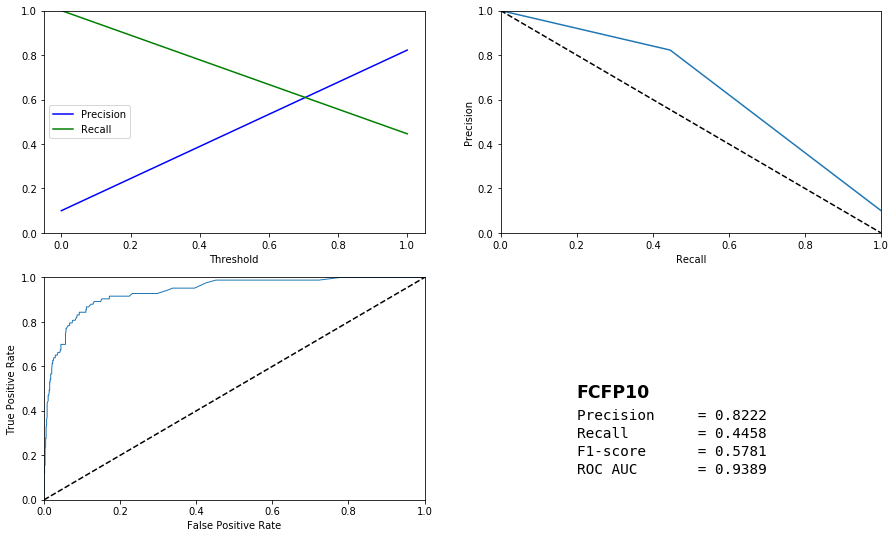



------------------------------------------------------------
Fingerprint: ECFP12
------------------------------------------------------------


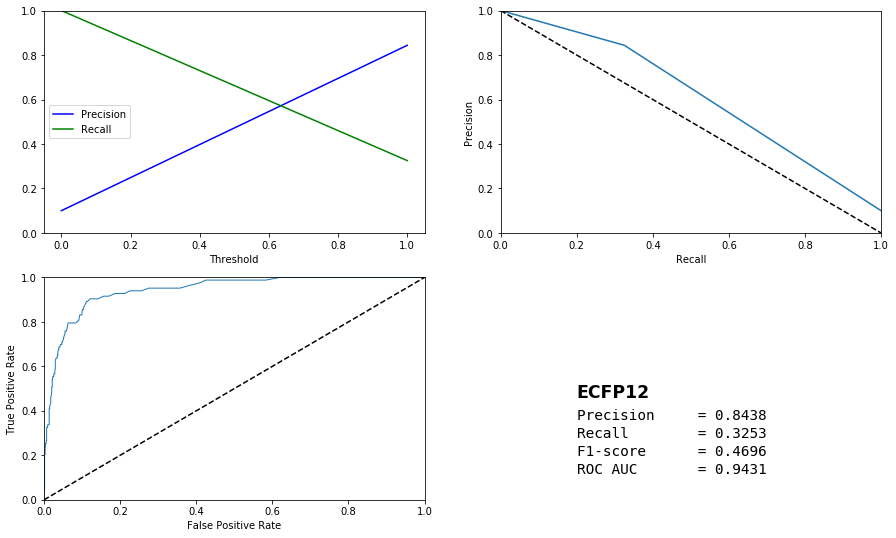



------------------------------------------------------------
Fingerprint: FCFP12
------------------------------------------------------------


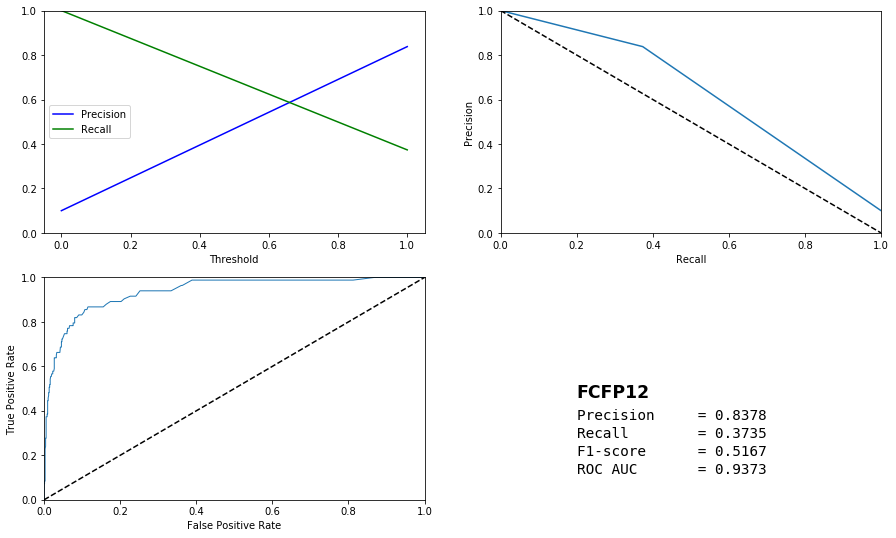

In [163]:
for radius in [2,3,4,5,6]:
    for fp in ["ECFP","FCFP"]:
        fp_name = fp + str(2*radius)
        fp_args = {"radius":radius}
        if fp == "ECFP":
            fp_args["use_features"] = False
        else:
            fp_args["use_features"] = True
        print("\n")
        print("-"*60)
        print(f"Fingerprint: {fp_name}")
        print("-"*60)
        data, res = test_fingerprint(data, train_test, fp_name, get_morgan_fp, **fp_args)
        results = results.append(res, ignore_index=True)

In [169]:
results

,Model,Precision,Recall,F1_Score,ROC_AUC
0,ECFP4,0.837209,0.433735,0.571429,0.954036
1,FCFP4,0.826923,0.518072,0.637037,0.949360
2,ECFP6,0.790698,0.409639,0.539683,0.953874
3,FCFP6,0.829787,0.469880,0.600000,0.949247
4,ECFP8,0.761905,0.385542,0.512000,0.945073
5,FCFP8,0.844444,0.457831,0.593750,0.942682
6,ECFP10,0.783784,0.349398,0.483333,0.945073
7,FCFP10,0.822222,0.445783,0.578125,0.938855
8,ECFP12,0.843750,0.325301,0.469565,0.943078
9,FCFP12,0.837838,0.373494,0.516667,0.937280


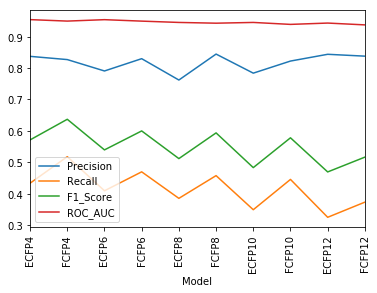

In [173]:
results.plot(x="Model", rot=90)

# Test Combined FPs

In [187]:
fcfp4 = data.iloc[1]['FCFP4']
fcfp8 = data.iloc[1]['FCFP4']

In [188]:
(np.hstack((fcfp4,fcfp8))).shape

(4096,)

In [ ]:
def get_combined_morgan_fp()

In [189]:
data.columns

Index(['PUBCHEM_SID', 'mol', 'ActiveBit', 'ECFP4', 'FCFP4', 'ECFP6', 'FCFP6', 'ECFP8', 'FCFP8', 'ECFP10', 'FCFP10', 'ECFP12', 'FCFP12'], dtype='object')



------------------------------------------------------------
Fingerprint: ECFP4+6
------------------------------------------------------------


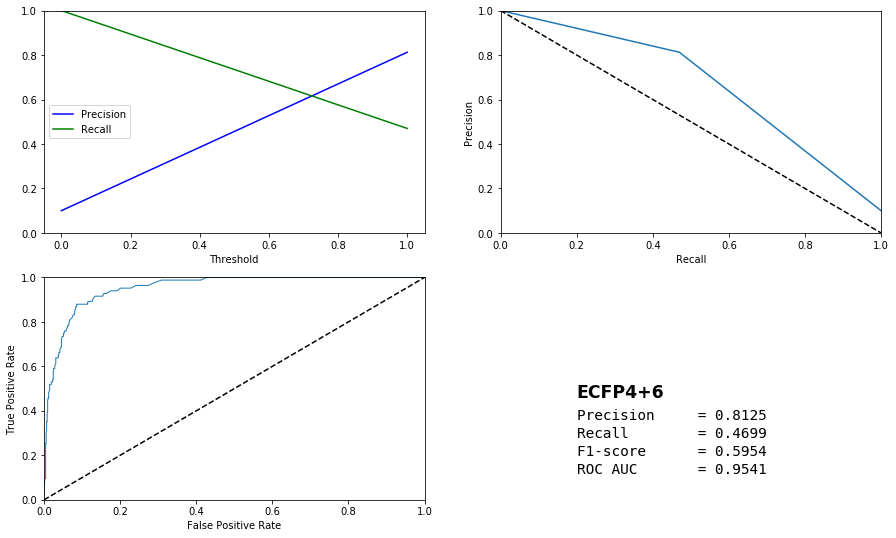



------------------------------------------------------------
Fingerprint: ECFP4+6+8
------------------------------------------------------------


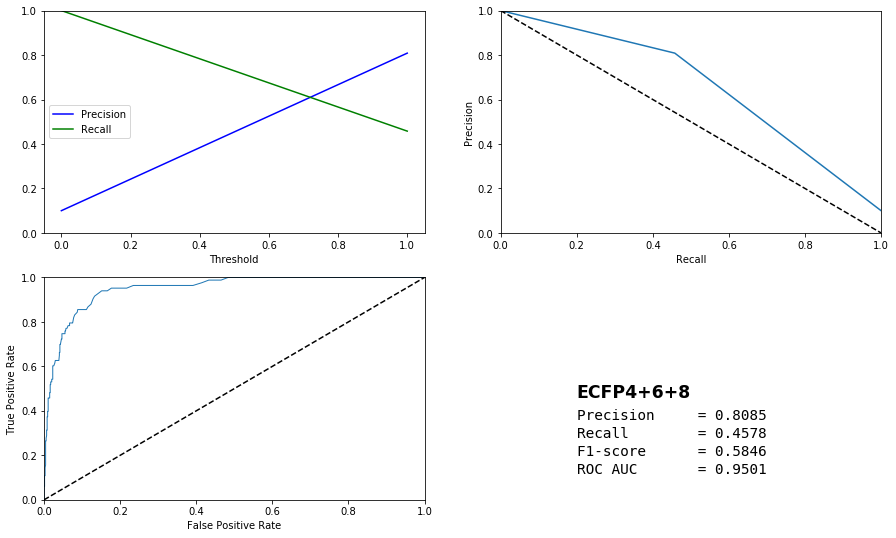



------------------------------------------------------------
Fingerprint: ECFP4+6+8+10
------------------------------------------------------------


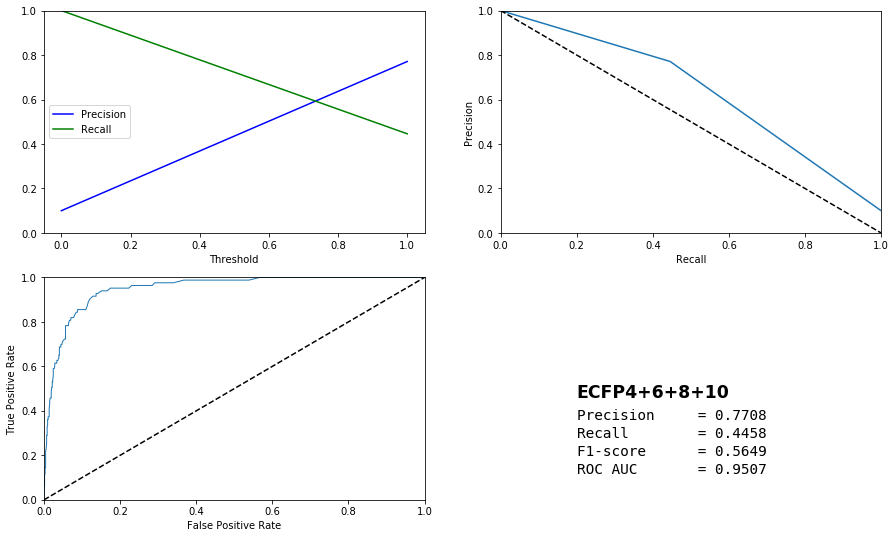



------------------------------------------------------------
Fingerprint: ECFP4+6+8+10+12
------------------------------------------------------------


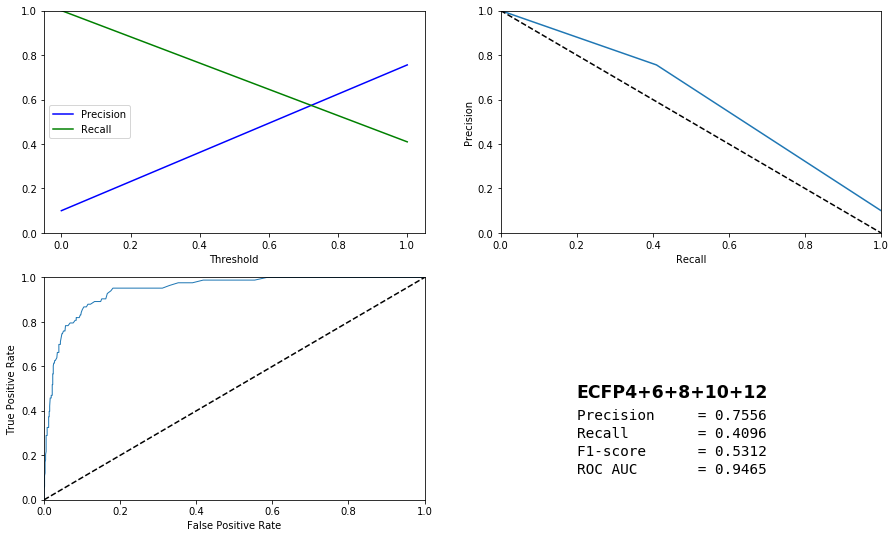



------------------------------------------------------------
Fingerprint: FCFP4+6
------------------------------------------------------------


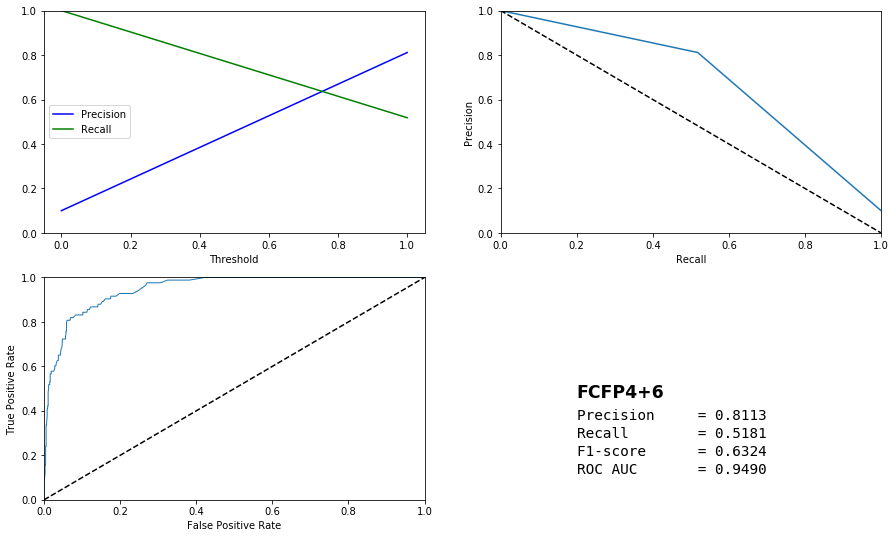



------------------------------------------------------------
Fingerprint: FCFP4+6+8
------------------------------------------------------------


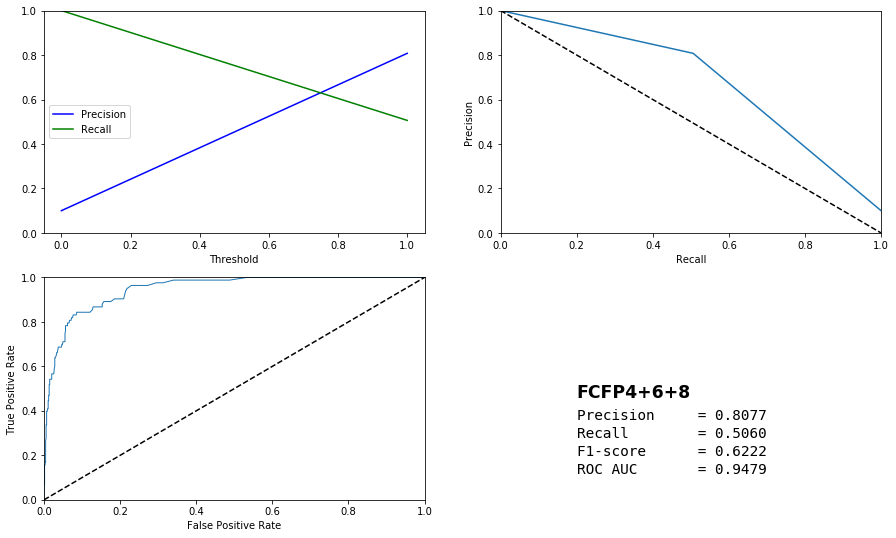



------------------------------------------------------------
Fingerprint: FCFP4+6+8+10
------------------------------------------------------------


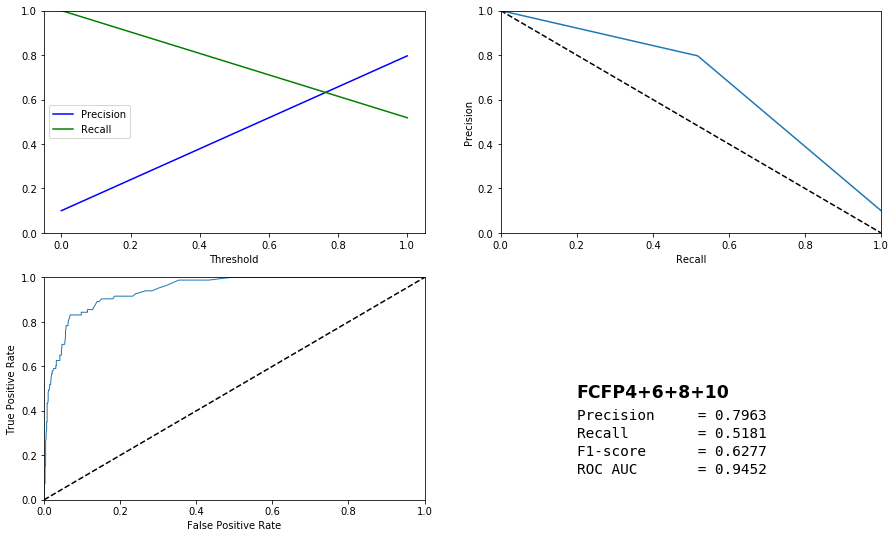



------------------------------------------------------------
Fingerprint: FCFP4+6+8+10+12
------------------------------------------------------------


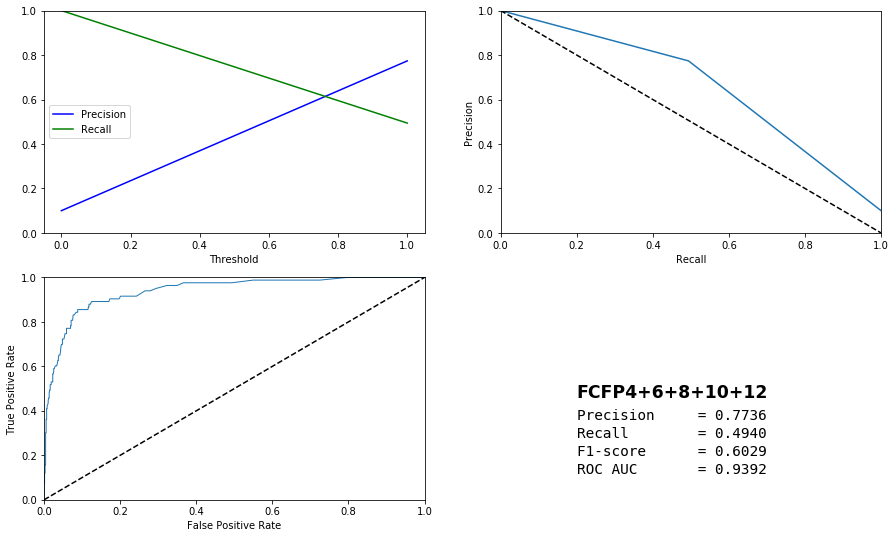

In [231]:
for fp in ['ECFP', 'FCFP']:
    comb_fp = fp + str(4)
    for radius in [3,4,5,6]:
        fp_name = fp + str(2*radius)
        new_col = comb_fp + "+" + str(2*radius)
        print("\n")
        print("-"*60)
        print(f"Fingerprint: {new_col}")
        print("-"*60)
        
        # Create a new column in data with the combined fp
        comb_values = []
        for i, row in data.iterrows():
            comb_values.append(np.hstack((row[comb_fp], row[fp_name])))
            
        data[new_col] = comb_values
        res = test_combined_fingerprint(data, train_test, new_col)
        results = results.append(res, ignore_index=True)
        comb_fp = new_col

# Results

In [304]:
results["Type"] = results["Model"].apply(lambda x: x[:4])
results["Radius"] = results["Model"].apply(lambda x: eval(x[4:].replace("+","*"))   )

results.sort_values(by=["Type","Radius"], inplace=True)
results.reset_index(drop=True, inplace=True)
results.drop(labels=["Type","Radius"], axis=1, inplace=True)

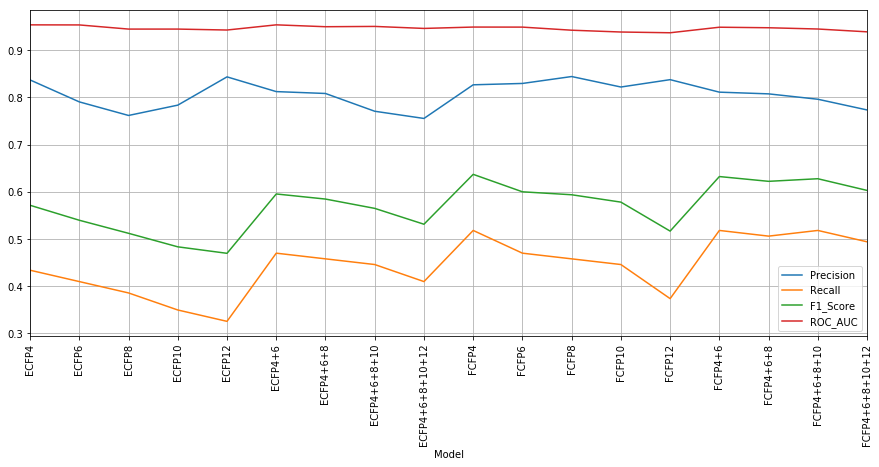

In [305]:
results.plot(x="Model", rot=90, figsize=(15,6), grid=True, xticks=range(0,18))

In [309]:
def combine_cols(col1, col2, new_col):
        comb_values = []
        for i, row in data.iterrows():
            comb_values.append(np.hstack((row[col1], row[col2])))
            
        data[new_col] = comb_values
        return test_combined_fingerprint(data, train_test, new_col)
        

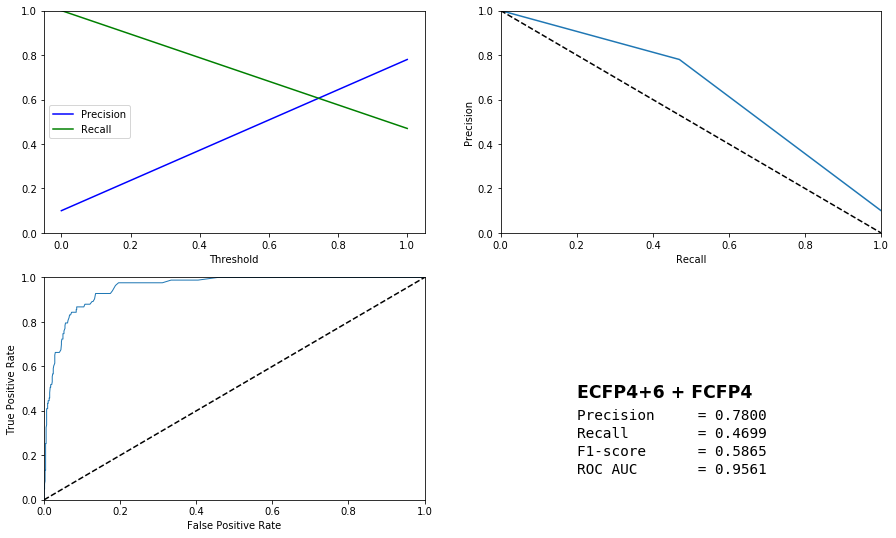

In [310]:
col1 = "ECFP4+6"
col2 = "FCFP4"
new_col = "ECFP4+6 + FCFP4"
results = results.append(combine_cols(col1, col2, new_col), ignore_index=True)

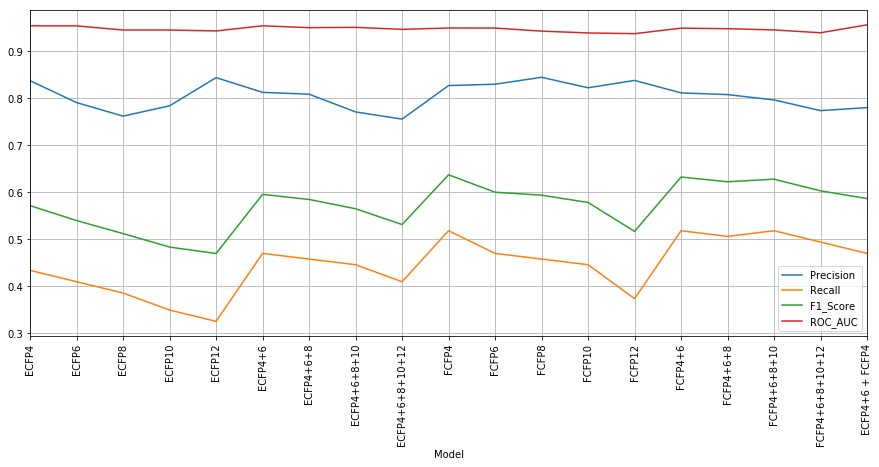

In [314]:
results.plot(x="Model", rot=90, figsize=(15,6), grid=True, xticks=range(len(results["Model"])))